---
title: Taking Derivatives with Automatic Differentiation
author: Mark Fuge
date: 'October 1 2025'
format:
    html:
        code-fold: false
---

Taking derivatives with respect to functions or parameters is one of the most common and fundamental operations that we will need for Machine Learning (and in fact for Scientific Computing, in general). Throughout your life so far, you have probably learned about three main ways to compute derivatives:

1. **Analytical Differentiation**: computing the analytical derivative manually using the rules of calculus and pencil and paper. The benefit of this approach is that it is exact, but the drawback is that it can be tedious, manual, and error-prone for complex functions. Once completed, we get a function that has the exact derivative everywhere.
2. **Symbolic Differentiation**: using a computer algebra system (CAS) to compute the analytical derivative symbolically. The main benefit of this approach is that it is exact and can handle more complex functions than manual differentiation, but the drawback is that it can be slow and may produce very complicated expressions that are difficult to evaluate numerically (a phenomenon known as *expression swell*). This method also produces a function that has the exact derivative everywhere as a single (often very large) function.
3. **Numerical Differentiation**: using finite difference approximations to compute the derivative numerically, for example using the formula $\frac{df}{dx} \approx \frac{f(x+h) - f(x)}{h}$ for some small $h$. The main benefit of this approach is that it is easy to implement and can handle any function that can be evaluated numerically, but its drawbacks are that it only approximates the derivative, can be sensitive to the choice of $h$, suffers from numerical precision issues, and only provides the derivative at a single evaluated point (unlike analytical or symbolic approaches that produce a function of the derivative that is valid everywhere).

This chapter won't cover those approaches in detail, as its main goal is to introduce you to a fourth way to compute derivatives called *Automatic Differentiation* (AD). This approach inherits some of the benefits of analytical and symbolic differentiation, in that it computes *exact* derivatives (unlike numerical differentiation). It's main drawback is that the effort used to compute the derivatives will be only useful for a single evaluation point (similar to numerical differentiation). Unlike symbolic differentiation, AD is very efficient and does not suffer from expression swell, although it does require extra bookkeeping to keep track of intermediate values and derivatives (as we will see), which can add some memory and computational overhead.

| Method                     | Benefits                                                                 | Drawbacks                                                                 |
|----------------------------|--------------------------------------------------------------------------|---------------------------------------------------------------------------|
| Analytical Differentiation  | Exact derivatives, valid everywhere                                    | Tedious, manual, error-prone for complex functions                       |
| Symbolic Differentiation    | Exact derivatives, can handle complex functions                         | Slow, may produce complicated expressions (expression swell)            |
| Numerical Differentiation   | Easy to implement, handles any numerically evaluable function          | Only approximates derivative, sensitive to $h$, precision issues, pointwise |
| Automatic Differentiation   | Exact derivatives, efficient computation                               | More complex implementation, potential overhead                        |

: Overview of different methods for computing derivatives.

With this overview in mind, we can now introduce Automatic Differentiation using a simple example, and then later demonstrate how to use it via some practical examples.

## Automatic Differentiation

To demonstrate how Automatic Differentiation works, let's take a simple example function, for which we can easily compute the derivatives manually/analytically, so that we can check out results. Let's consider the function: 

$$
f(x_1, x_2) = \ln(x_1) + x_1 \cdot x_2 - \sin(x_2)
$$  

evaluated at $x_1 = 2, x_2 = 5$.

Analytically, this function is simple enough that we could actually compute the partial derivatives manually:
$$\frac{\partial y}{\partial x_0} = \frac{1}{x_0} + x_1 = 0.5 + 5 = 5.5$$

$$\frac{\partial y}{\partial x_1} = x_0 - cos(x_1) = 2 - 0.284 = 1.716$$

However, for the sake of this example, we will use Automatic Differentiation to compute these derivatives instead. The first step of Automatic Differentiation is to build up a *Computational Graph* of the function using a library of easy to compute derivatives (e.g., $\frac{\partial}{\partial x} x^n \rightarrow n\cdot x^{n-1}$)

### Build the Computational Graph

To build the computational graph, we break the function down into its elementary operations step by step, starting from the beginning (i.e., the inputs to the function). We will introduce intermediate variables ($V_\#$) to represent the outputs of these intermediate operations. Let's define:


```{mermaid}
graph LR
    %% Input nodes
    V0((V0 = x1))
    V1((V1 = x2))
    %% Intermediate nodes
    V2((V2 = ln V0))
    V3((V3 = V0 x V1))
    V4((V4 = -sin V1))
    V5((V5 = V2 + V3))
    V6((V6 = V5 + V4 = f))

    %% Operations
    V0 --> V2
    V0 --> V3
    V1 --> V3
    V1 --> V4

    %% Sum nodes
    V2 --> V5
    V3 --> V5
    V5 --> V6
    V4 --> V6
```

Now with the graph in place, we can compute the first stage of Automatic Differentiation, which is the *forward pass* through the function.

### Compute the Forward Pass

The Forward Pass is simply evaluating the function at the given input values, but we will do this step by step, following the computational graph we just built. It will be useful to keep track of the intermediate values in a table for reference later. (In reality, the computer will do this for us, but we are doing it by hand here to illustrate the process.)

| Node | Definition                | Value                         |
|------|----------------------------|-------------------------------|
| $V0$   | $x_1$                    | 2                             |
| $V1$   | $x_2$                    | 5                             |
| $V2$   | $\ln(V0)$                | $\ln(2) \approx 0.6931$     |
| $V3$   | $V0 \cdot V1$            | $2 \cdot 5 = 10$            |
| $V4$   | $-\sin(V1)$              | $-\sin(5) \approx 0.9589$   |
| $V5$   | $V2 + V3$                | $0.6931 + 10 = 10.6931$     |
| $V6$   | $V5 + V4$                | $10.6931 + 0.9589 \approx 11.6520$ |

If we pass in our initial points (x1, x2) through this forward pass, we can look at the final node (V6) to get the answer: 
$$
f(2, 5) \approx 11.6520
$$




Great, this matches what we would expect. At this point, we have just evaluated the function forward, and we don't yet have any derivatives. From here, things get interesting and bifurcate into two main types of Automatic Differentiation: Forward Mode AD and Backward Mode AD. Each of these has important but different uses for reasons that will become clear as we work through the example. Let's start with Forward Mode AD. In both cases, we will start with the initial work we already did with the forward pass above.

### Computing Forward Mode AD (tangent propagation)

Forward Mode AD allows us to compute *directional derivatives* of the function, as well as that same directional derivative at *any intermediate node* in the computational graph. This is useful for computing derivatives of functions that have a small number of inputs (e.g., 1-10), but potentially a large number of outputs that we might be interested in. For example, if we were computing a trajectory of a dynamical system, we might want to know how the final state of the system changes with respect to some initial condition. In this case, the initial condition is the input, and the final state is the output. There might be many intermediate states along the way that we also want to know how they change with respect to the initial condition, such as the state or total energy at each time step. Forward Mode AD allows us to compute all of these derivatives in only a single pass through the computational graph.

To see how this works, we will introduce a new variable $\dot{V}$ to represent the derivative of each node with respect to some input direction. We will use the notation $\dot{V} = \frac{dV}{dx}$, where $x$ is some input variable.

**Case A: derivative wrt $x_1$ ($\dot{x}_1 = 1, \dot{x}_2 = 0$)**

| Node | Definition                        | Value                         |
|------|-----------------------------|-------------------------------|
| $\dot{V_0}$   | $\dot{x_1}$                 | 1                             |
| $\dot{V_1}$   | $\dot{x_2}$                 | 0                             |
| $\dot{V_2}$   | $d(\ln V_0)/dV_0 = 1/V_0 \dot{V_0}$   | $(1/2)\cdot 1 = 0.5$        |
| $\dot{V_3}$   | $d(V_0 \cdot V_1)/dV_0 = \dot{V_0} V_1 + V_0 \dot{V_1}$  | $5\cdot1+2\cdot0=5$ |
| $\dot{V_4}$   | $-\cos(V_1)\dot{V_1}$      | $-\cos(5)\cdot 0 = 0$       |
| $\dot{V_5}$   | $\dot{V_3} + \dot{V_2}$    | $0.5 + 5 = 5.5$             |
| $\dot{V_6}$   | $\dot{V_5} + \dot{V_4}$    | $5.5 + 0 = 5.5$             |

$$
\frac{\partial f}{\partial x_1} = 5.5
$$



**Case B: derivative wrt $x_2$ ($\dot{x}_1 = 0, \dot{x}_2 = 1$)**

**Exercise:** Fill in a similar table as above to compute the derivative of the function with respect to $x_2$ using Forward Mode AD.

You can check your answer using the known analytical derivative of the function that you can compute by hand:
$$
\frac{\partial f}{\partial x_2} \approx 1.7163
$$

OK, great, we see that with some bookkeeping, we have correctly computed the derivatives of the function with respect to each input variable. Note that we had to do two passes through the computational graph to get both derivatives, since they were different directional derivatives. If we had a third input variable, we would need a third pass, and so on. This is why Forward Mode AD is best suited for functions with a small number of inputs.

On the flip side, if we were interested in the derivative of some intermediate node in the computational graph with respect to an input variable, we would have that information available as well. For example, if we wanted to know how $V3$ changes with respect to $x_1$, we can see from the table above that $\frac{\partial V3}{\partial x_1} = 5$. We got this in the process of computing the final function, so this derivative comes "along for the ride" without additional cost on our part. This is a powerful feature of Forward Mode AD that we will see is not available in Backward Mode AD: we can get a specific directional derivatives of any intermediate node from the computational graph via the same Forward Mode pass, but the cost of this scales with the number of input variables or number of directional derivatives we want to compute.




### Computing Reverse Mode AD (backpropagation)

While Forward Mode AD efficiently found directional derivatives, if we wanted to compute the full gradient of the output with respect to all of the input variables, we would need to do a separate pass for each input variable. This means that the cost of computing the full gradient scales with the number of input variables. If we have a function with a large number of input variables (e.g., 1000s or more), this can be very expensive. To address this, we can use Reverse Mode AD, which will allow us to compute the full gradient of every input variable to a function using a single "backward pass" through the computational graph. This is particularly useful for functions that have a small number of outputs (e.g., 1-10), but a very large number of inputs, such as a Neural Network in Machine Learning or mesh coordinates in a Finite Element or Computational Fluid Dynamics simulation.

To see how this works, we will introduce a new variable $\bar{V}$ to represent the *adjoint* of each node with respect to the output. We will use the notation $\bar{V} = \frac{\partial f}{\partial V}$, where $f$ is the final output of the function. The adjoint represents how much a small change in that intermediate node would affect the final output of the function.

Similarly to Forward Mode AD, we will have to pick a specific output that we wish to compute the gradient with respect to. In this case, since we are computing the gradient of the output with respect to all input variables, we can set the final output node with a value of 1, i.e., $\bar{V6} = 1$. From there, we will propagate each adjoint backward through the computational graph using the chain rule.





| Node | Equation for the adjoint        | Value                         |
|------|-----------------------------|-------------------------------|
| $\bar{V_6}$   | $\frac{\partial f}{\partial V_6}$ | 1                             |
| $\bar{V_5}$   | $\frac{\partial f}{\partial V_6} \frac{\partial V_6}{\partial V_5} = \bar{V_6}1$ | 1                             |
| $\bar{V_4}$   | $\frac{\partial f}{\partial V_6} \frac{\partial V_6}{\partial V_4} = \bar{V_6}1$ | 1                             |
| $\bar{V_3}$   | $\frac{\partial f}{\partial V_5} \frac{\partial V_5}{\partial V_3} = \bar{V_5}1$ | 1                             |
| $\bar{V_2}$   | $\frac{\partial f}{\partial V_5} \frac{\partial V_5}{\partial V_2} = \bar{V_5}1$ | 1                             |
| $\bar{V_1}$   | from V3: $\bar{V_3}\cdot V_1=2$ <br> + from V4: $-\cos(5)\cdot \bar{V_4} \approx -0.2837$ | 1.7163 |
| $\bar{V_0}$   | from V2: $\bar{V_2}(1/V_0)\cdot1=0.5$ <br> + from V3: $\bar{V_3}\cdot V_1=5$ | 5.5 |

We can now verify the final gradients, which match our analytical solution:

$$
\nabla f(2,5) = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2} \right) = (5.5, \, 1.7163)
$$


However, unlike Forward Mode AD, we see that we now have access not only to the gradients of the input variables, but also to the gradients of **all intermediate nodes** in the computational graph, and we received all of them via the same amount of work/computation!




## PyTorch Autograd Example with Simple Function
Ok let's use automatic differentiation to compute a simple derivative of our earlier analytical function:

$$y = f(x_0,x_1) = \ln(x_0) + x_0 \cdot x_1 - \sin(x_1)$$

And as with before, we'll evaluate the derivative of this function at $$x_0 = 2, x_1=5$$

We can analytically compute the derivative and code it up so that we can verify accuracy later:

In [1]:
#| code-fold: false
import numpy as np
def true_grad(x0,x1):
    return np.array([
        1/x0 + x1,
        x0 - np.cos(x1)
    ])
true_grad(2,5)

array([5.5       , 1.71633781])

But now let's see how to use [PyTorch](https://pytorch.org/ ) to get this using Automatic Differentiation:

### Automatic Differentiation using PyTorch

In [2]:
import torch
x = torch.tensor([2.0, 5.0], requires_grad=True)
print(x)

tensor([2., 5.], requires_grad=True)


In [3]:
def f(x):
    return torch.log(x[0]) + x[0]*x[1] - torch.sin(x[1])
y = f(x)
print(y)

tensor(11.6521, grad_fn=<SubBackward0>)


In [4]:
x.grad

In [5]:
# Now call the backward AD pass so that we can compute gradients
y.backward()
# Now we can ask for the gradient:
x.grad

tensor([5.5000, 1.7163])

Let's see how well it approximated the true gradient:

In [6]:
true_grad(2,5) - x.grad.numpy()

array([0.00000000e+00, 1.45108339e-08])

### Finite Differences using SciPy

Now let's compare this to computing the same gradient, but using Numerical Differentiation (specifically, Central Finite Differences):

In [7]:
from scipy import optimize
x_np = np.array([2.0, 5.0])
def f_np(x):
    return np.log(x[0]) + x[0]*x[1] - np.sin(x[1])
#y_np = f_np(x_np)
# This computes finite differences opf f_np at x_np:
optimize.approx_fprime(x_np, f_np, epsilon=1e-4)

array([5.4999875 , 1.71628987])

Let's see how well it approximated the true gradient:

In [8]:
true_grad(2,5) - optimize.approx_fprime(x_np, f_np, epsilon=1e-4)

array([1.24995903e-05, 4.79457300e-05])

In [9]:
def numerical_error(e):
    return true_grad(2,5) - optimize.approx_fprime(x_np, f_np, epsilon=e)
#error = lambda e: true_grad(2,5) - optimize.approx_fprime(x_np, y_np, epsilon=e)
epsilons = np.logspace(-13,1,num=21)
errors = [np.linalg.norm(numerical_error(e)) for e in epsilons]

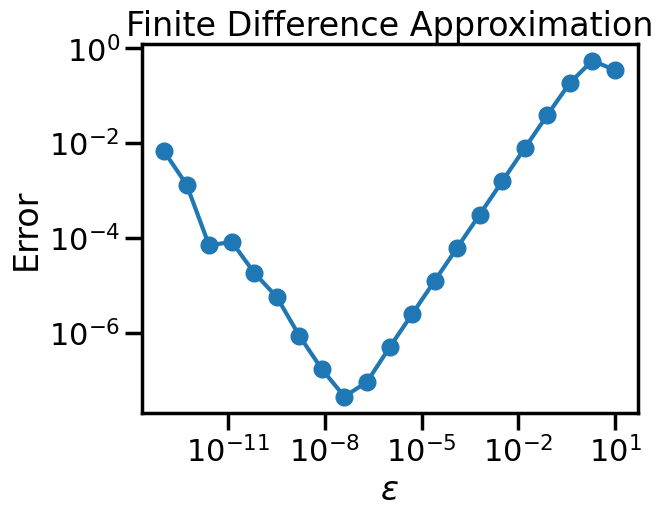

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
np.random.seed(1)

plt.figure()
plt.loglog(epsilons,errors,marker='o')
plt.xlabel('$\epsilon$')
plt.ylabel('Error')
plt.title('Finite Difference Approximation')
plt.show()

## PyTorch Autograd Example with Optimization

This example shows how to use AD and PyTorch to perform gradient based optimization on a simple test function

In [11]:
# Example of the McCormick Function
def mccormick(x):
    return torch.sin(x[0]+x[1]) + (x[0]-x[1])**2 - 1.5*x[0]+2.5*x[1]+1
f = mccormick

x = torch.tensor([-4.0, 4.0], requires_grad=True)
y = f(x)

What does this function look like?

c:\Users\fuge\AppData\Local\miniforge3\envs\ml4me-student\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


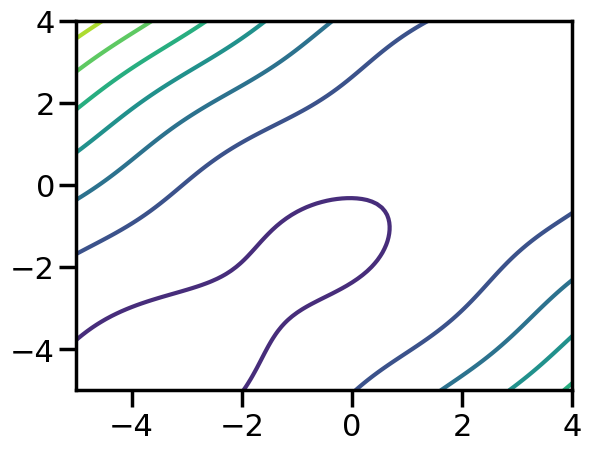

In [12]:
X_plot = torch.meshgrid(torch.linspace(-5,4,100),torch.linspace(-5,4,100))
x_plot,y_plot = X_plot
plt.figure()
plt.contour(x_plot,y_plot,f(X_plot))
plt.show()

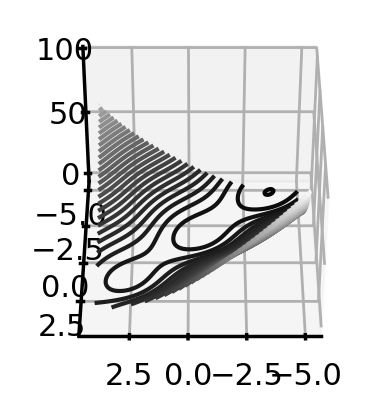

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(x_plot, y_plot, f(X_plot), 50, cmap='binary_r')
ax.view_init(40, 90)
plt.show()

Now let's say I want to optimize this. I could compute the analytical derivative. Or, I could compute the backward-mode AD on the inputs:

In [14]:
# Pick a starting point:
x = torch.tensor([-4.0, 4.0], requires_grad=True)
# Evaluate y
y = f(x)
# Now call the backward AD pass so that we can compute gradients
y.backward()
# Now we can get the gradient
x.grad

tensor([-16.5000,  19.5000])

Now we just stick it in a loop and run SGD on it:

In [15]:
# Take an initial guess at the optimum:
x = torch.tensor([-4.0, 4.0], requires_grad=True)
# Note that the true answer should be x_opt = [5, 5]
# Initialize the optimizer
optimizer = torch.optim.AdamW([x], lr=1)
num_steps = 50
steps = [np.array(x.detach().numpy())]
# Take 10 steps
for i in range(num_steps):
    optimizer.zero_grad()
    y = f(x)
    y.backward()
    optimizer.step()
    with torch.no_grad():
        steps.append(np.array(x.detach().numpy()))
        print(x)
steps = np.array(steps)

tensor([-2.9600,  2.9600], requires_grad=True)
tensor([-1.9481,  1.9436], requires_grad=True)
tensor([-0.9857,  0.9653], requires_grad=True)
tensor([-0.1051,  0.0453], requires_grad=True)
tensor([ 0.6508, -0.7906], requires_grad=True)
tensor([ 1.2368, -1.5138], requires_grad=True)
tensor([ 1.6219, -2.0992], requires_grad=True)
tensor([ 1.8020, -2.5325], requires_grad=True)
tensor([ 1.7979, -2.8129], requires_grad=True)
tensor([ 1.6423, -2.9514], requires_grad=True)
tensor([ 1.3704, -2.9664], requires_grad=True)
tensor([ 1.0147, -2.8804], requires_grad=True)
tensor([ 0.6043, -2.7165], requires_grad=True)
tensor([ 0.1659, -2.4983], requires_grad=True)
tensor([-0.2759, -2.2482], requires_grad=True)
tensor([-0.6981, -1.9879], requires_grad=True)
tensor([-1.0796, -1.7375], requires_grad=True)
tensor([-1.4026, -1.5143], requires_grad=True)
tensor([-1.6534, -1.3326], requires_grad=True)
tensor([-1.8238, -1.2020], requires_grad=True)
tensor([-1.9113, -1.1271], requires_grad=True)
tensor([-1.91

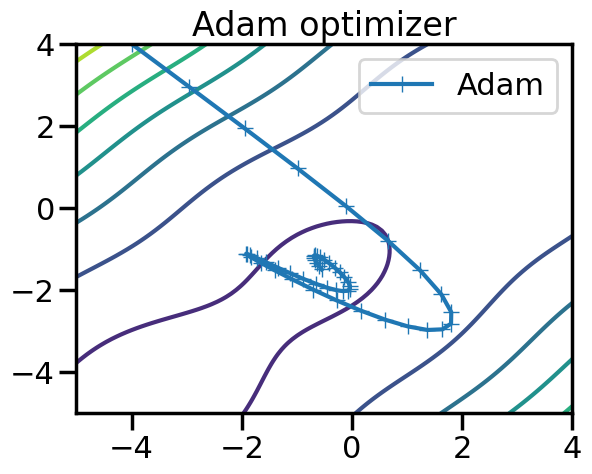

In [16]:
plt.figure()
plt.contour(x_plot,y_plot,f(X_plot))
plt.plot(steps[:,0],steps[:,1],marker='+',label = "Adam")
plt.legend()
plt.title("Adam optimizer")
plt.show()

In [17]:
# Take an initial guess at the optimum:
x = torch.tensor([-4.0, 4.0], requires_grad=True)
# Note that the true answer should be x_opt = [5, 5]
# Initialize the optimizer
# Here using LBFGS, which is much faster convergence on small problems
optimizer = torch.optim.LBFGS([x],lr=0.05)
num_steps = 5
steps = [np.array(x.detach().numpy())]
# Take 10 steps
for i in range(num_steps):
    def closure():
        optimizer.zero_grad()
        y = f(x)
        y.backward()
        return y
    optimizer.step(closure)
    with torch.no_grad():
            steps.append(np.array(x.detach().numpy()))
            print(x)
steps = np.array(steps)

tensor([-1.9382,  0.4356], requires_grad=True)
tensor([-1.0402, -0.8307], requires_grad=True)
tensor([-0.7223, -1.2888], requires_grad=True)
tensor([-0.6097, -1.4543], requires_grad=True)
tensor([-0.5696, -1.5139], requires_grad=True)


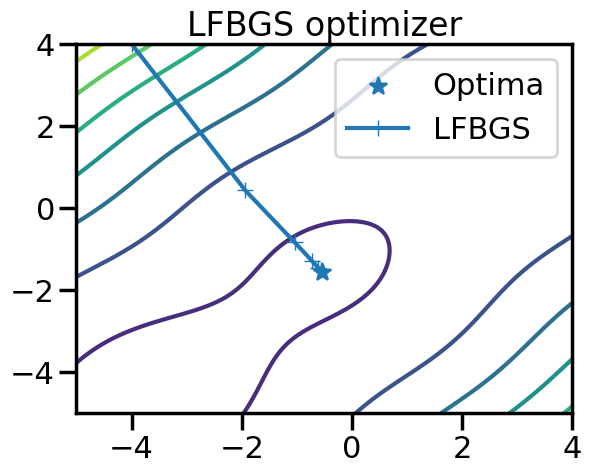

In [18]:
plt.figure()
plt.contour(x_plot,y_plot,f(X_plot))
plt.scatter([-0.54719],[-1.54719],marker='*',label="Optima")
plt.plot(steps[:,0],steps[:,1],marker='+',label = "LFBGS")
plt.legend()
plt.title("LFBGS optimizer")
plt.show()

## Demonstration of AD on Verlet Integration
This notebook demonstrates how to use Automatic Differentiation to determine the gradients of the initial conditions of a dynamical system (in this case a damped oscillator). To do this, we will define a numerical routine ([Verlet Integration](https://en.wikipedia.org/wiki/Verlet_integration)) and then use Automatic Differentiation to back propagate the gradient information from the output (Total system energy) to the initial conditions.

Below is a typical simulation script that is not current set up for automatic differentiation:

In [19]:

###############################################################################
N = 1000
t = np.linspace(0,10,N)
dt = t[1] - t[0]

###############################################################################
# functions
def integrate_original(F,x0,v0,gamma):
    ###########################################################################
    # arrays are allocated and filled with zeros
    Ef = 0
    x = np.zeros(N)
    v = np.zeros(N)
    E = np.zeros(N)
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v[0] = v0
    
    ###########################################################################
    # Do the Verlet Integration
    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)
    
    for i in range(N-1):
        vn = fac1*fac2*v0 - fac2*dt*x0 + fac2*dt*F[i]
        xn = x0 + dt*vn
        Ef = 0.5*(x0**2 + ((v0 + vn)/2.0)**2)
        v0 = vn
        x0 = xn
        # For Plotting/Debug

        v[i + 1] = vn
        x[i + 1] = xn
        E[i] = Ef

    Ef = 0.5*(x0**2 + v0**2)
    
    E[-1] = Ef
    
    ###########################################################################
    # return solution
    return ( (x0,v0,Ef) , (x,v,E) )

Now note how we modify the code to include AD via PyTorch (see comments and references to `torch`):

In [20]:

###############################################################################
N = 1000
t = np.linspace(0,10,N)
dt = t[1] - t[0]

###############################################################################
# functions
def integrate(F,x0,v0,gamma):
    ###########################################################################
    # arrays are allocated and filled with zeros
    #x = torch.tensor([0.0],requires_grad=True)
    #v = torch.zeros(N)
    Ef = torch.tensor([0.0],requires_grad=True)
    x = np.zeros(N)
    v = np.zeros(N)
    E = np.zeros(N)
    
    ###########################################################################    
    # initial conditions
    with torch.no_grad():
        x[0] = x0
        v[0] = v0
    
    ###########################################################################
    # Do the Verlet Integration
    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)
    
    for i in range(N-1):
        vn = fac1*fac2*v0 - fac2*dt*x0 + fac2*dt*F[i]
        xn = x0 + dt*vn
        Ef = 0.5*(x0**2 + ((v0 + vn)/2.0)**2)
        v0 = vn
        x0 = xn
        # For Plotting/Debug
        with torch.no_grad():
            v[i + 1] = vn
            x[i + 1] = xn
            E[i] = Ef
    
    Ef = 0.5*(x0**2 + v0**2)
    with torch.no_grad():
        E[-1] = Ef
    
    ###########################################################################
    # return solution
    return ( (x0,v0,Ef) , (x,v,E) )

In [21]:
###############################################################################
# Do the actual numerical integration
F = np.zeros(N)

x_initial = torch.tensor([1.0], requires_grad = True)
v_initial = torch.tensor([1.0], requires_grad = True)
#gamma = torch.tensor([0.05], requires_grad = True)
gamma = torch.tensor([.05], requires_grad = True)
((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,gamma) # x0 = 0.0, v0 = 1.0, gamma = 0.0

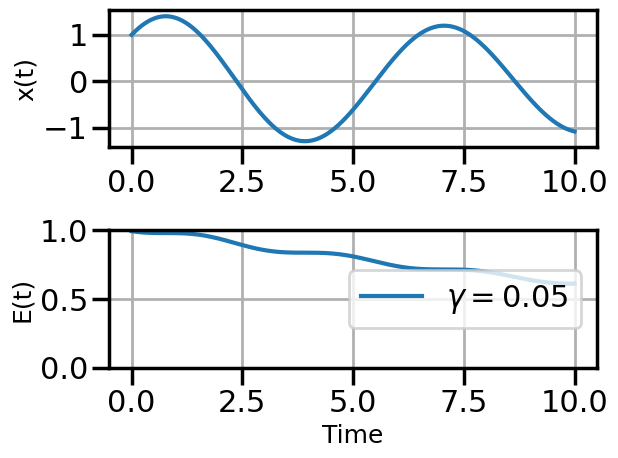

In [22]:
#((),(x2,v2,E2)) = integrate(F,0.0,1.0,0.05) # x0 = 0.0, v0 = 1.0, gamma = 0.01
#((),(x2,v2,E2)) = integrate(F,0.0,1.0,0.05) # x0 = 0.0, v0 = 1.0, gamma = 0.01

#((),(x3,v3,E3)) = integrate(F,0.0,1.0,0.4) # x0 = 0.0, v0 = 1.0, gamma = 0.5

###############################################################################
def plot_solution(x1,E1,gamma):
    plt.rcParams["axes.grid"] = True
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 18
    plt.figure()
    plt.subplot(211)
    plt.plot(t,x1)
    #plt.plot(t,x2)
    #plt.plot(t,x3)
    plt.ylabel("x(t)")

    plt.subplot(212)
    plt.plot(t,E1,label=fr"$\gamma = {float(gamma):.2f}$")
    #plt.plot(t,E2,label=r"$\gamma = 0.01$")
    #plt.plot(t,E3,label=r"$\gamma = 0.5$")
    plt.ylim(0,1.0)
    plt.ylabel("E(t)")

    plt.xlabel("Time")
    plt.legend(loc="center right")

    plt.tight_layout()

plot_solution(x1,E1,gamma)


In [23]:
print(Ef)
Ef.backward(retain_graph=True)

tensor([0.6137], grad_fn=<MulBackward0>)


Now let's print the gradient of the system Energy with respect to some of the initial conditions:

In [24]:
print(gamma.grad)
print(v_initial.grad)
print(x_initial.grad)

tensor([-5.9562])
tensor([0.6026])
tensor([0.6248])


In [25]:
print(vf)
vf.backward()

tensor([-0.2245], grad_fn=<AddBackward0>)


In [26]:
print(gamma.grad)
print(v_initial.grad)
print(x_initial.grad)

tensor([-4.7535])
tensor([-0.0437])
tensor([1.0466])


### Optimizing the Damping Coefficient via SGD and AD

First let's just get a visual intuition for how $\gamma$ affects the final energy:

In [27]:
num_gammas = 30
gamma_plot = np.logspace(-0.5,1.0,num_gammas)
Efs = np.zeros(num_gammas)
for i,g in enumerate(gamma_plot):
    ((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,g)
    Efs[i] = Ef

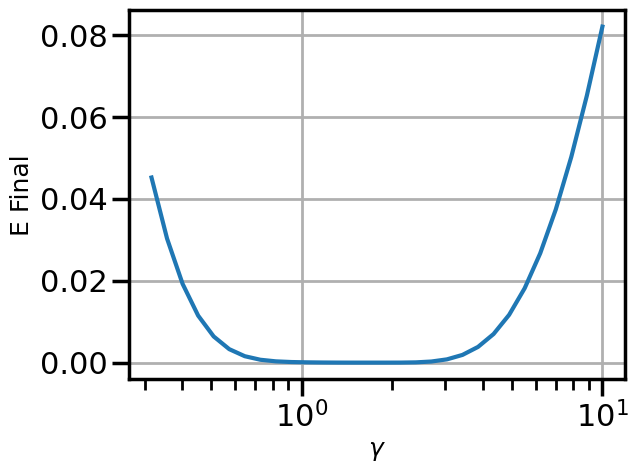

In [28]:
plt.figure()
plt.semilogx(gamma_plot,Efs)
plt.xlabel(r'$\gamma$')
plt.ylabel('E Final')
plt.show()

We can see that there is a pretty flat plateau from around $\gamma=1$ until around $\gamma=3$.

Now let's use our backward mode AD to actually optimize $\gamma$ directly by calling backward on the output of the final energy of the Verlet integration of the ODE:

In [29]:
# This part is just a helper library for plotting
def plot_optimization(initial_gamma, num_steps, optimizer, opt_kwargs={}):
    # Take an initial guess at the optimum:
    gamma = torch.tensor([initial_gamma], requires_grad=True)

    # Initialize the optimizer
    optimizer = optimizer([gamma], **opt_kwargs)

    steps = [ ] # Here is where we'll keep track of the steps
    # Take num_steps of the optimizer
    for i in range(num_steps):
        # This function runs an actual optimization step. We wrap it in closure so that optimizers
        # that take multiple function calls per step can do so -- e.g., LBFGS.
        def closure():
            # Get rid of the existing gradients on the tape
            optimizer.zero_grad()
            # Run the numerical integration -- this is the forward pass through the solver
            ((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,gamma) # x0 = 0.0, v0 = 1.0, gamma = 0.0
            # Compute the backward mode AD pass
            Ef.backward()
            return Ef
        # Now ask the optimizer to take a step
        optimizer.step(closure)
        
        # The below part is just for printing/plotting. We call torch.no_grad() here to signify that
        # we do not need to track this as part of the gradient operations. That is, these parts will not
        # be added to the computational graph or used for backward mode AD.
        with torch.no_grad():
            #print(gamma)
            # Run again just to plot the solution for this gamma
            ((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,gamma)
            #print(Ef)
            if num_steps>10 and i%3==0:
                plot_solution(x1,E1,gamma)
            # Add it to steps so that we can see/plot it later.
            steps.append(np.array(gamma.detach().numpy()))
            
    steps = np.array(steps)
    return steps

#### ADAM Example

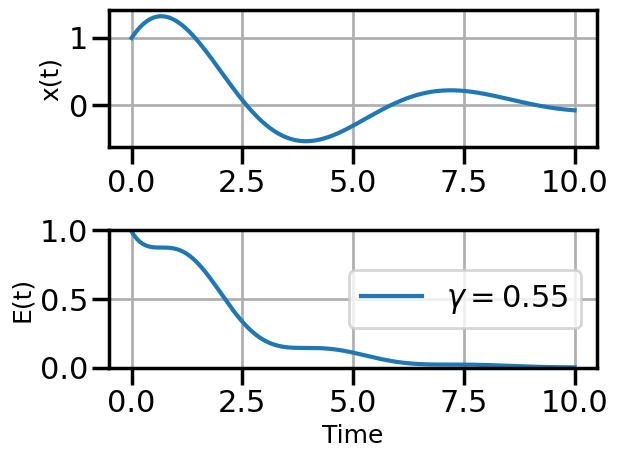

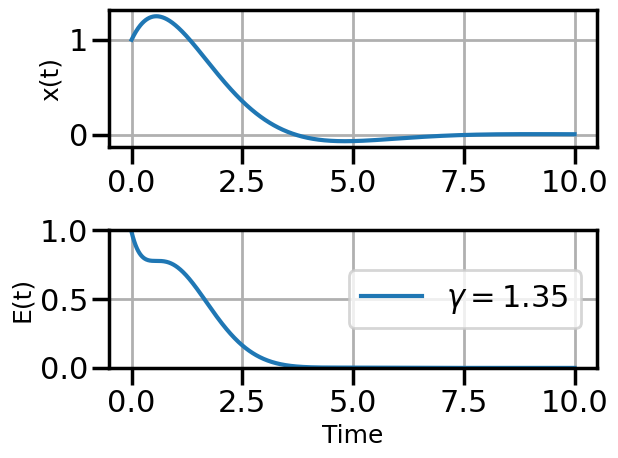

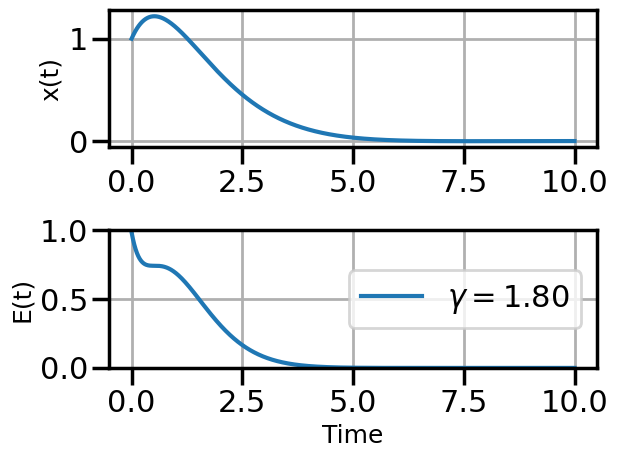

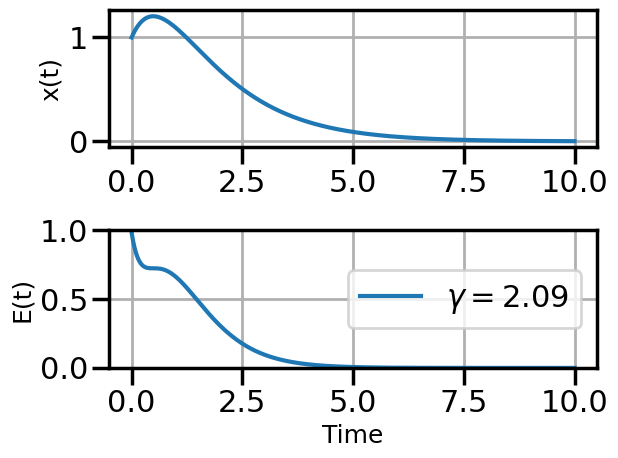

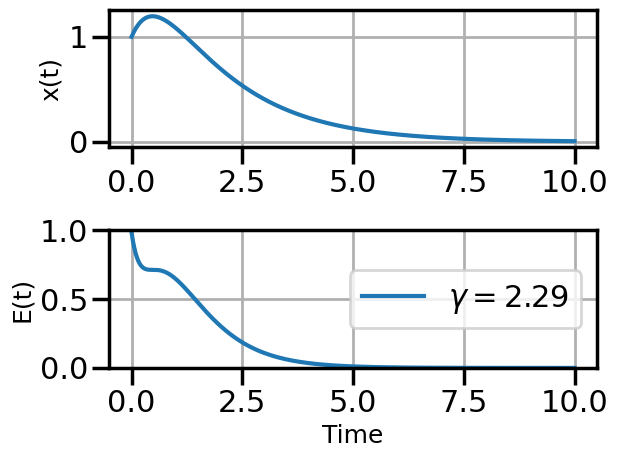

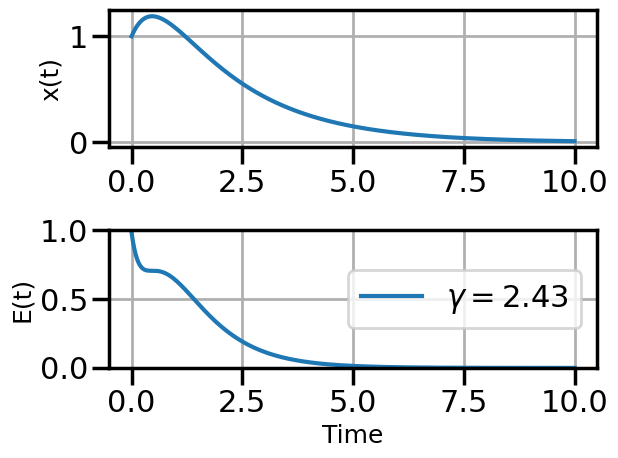

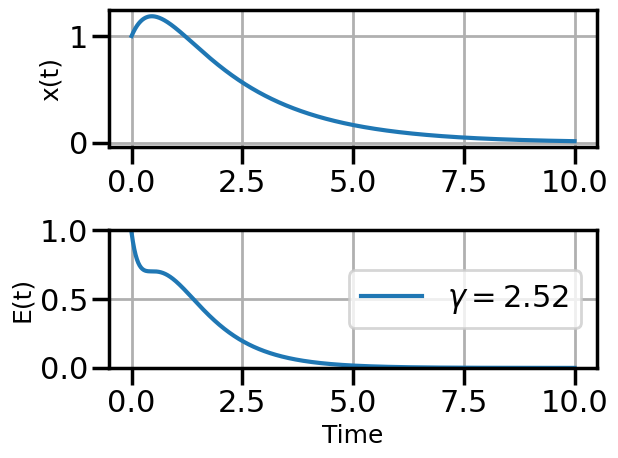

In [30]:
steps_Adam = plot_optimization(initial_gamma=0.05, 
                               num_steps=20,
                               optimizer=torch.optim.AdamW,
                               opt_kwargs={'lr':0.5})

#### SGD Example

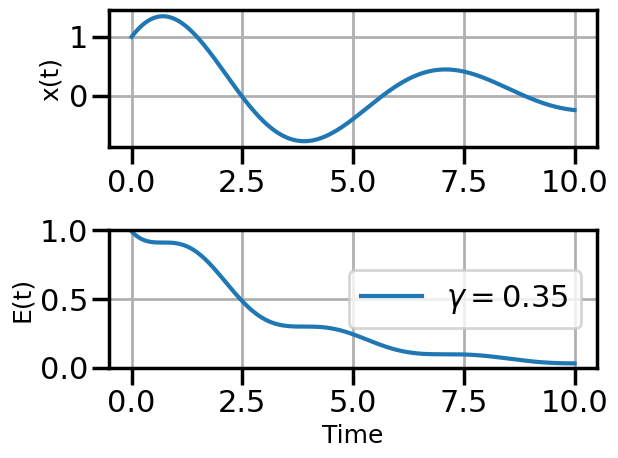

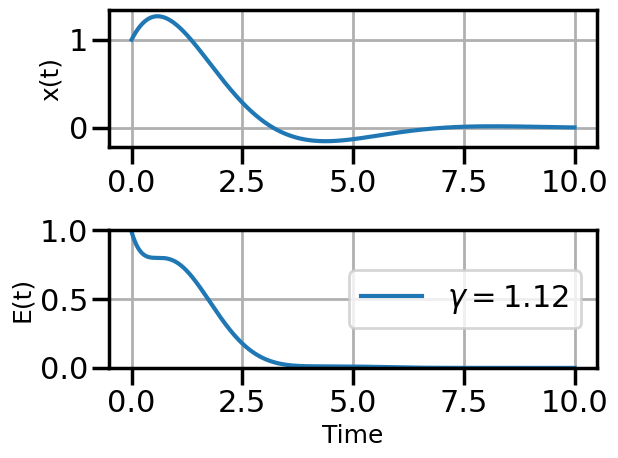

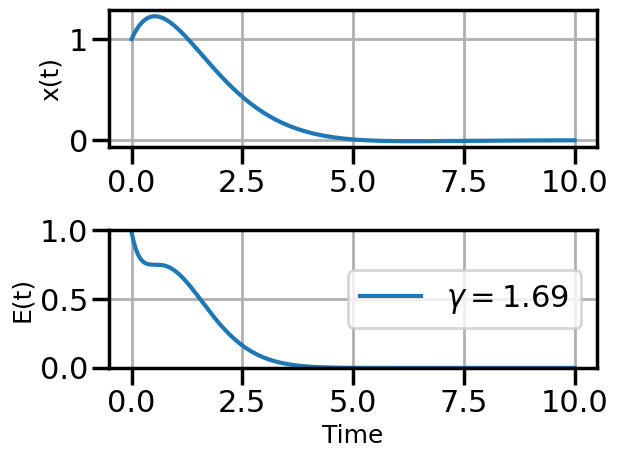

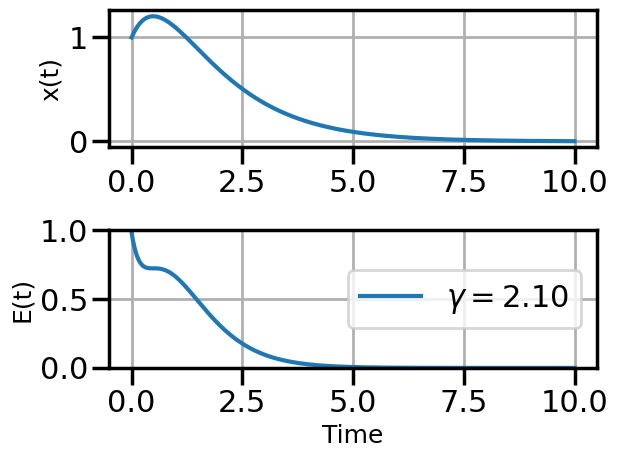

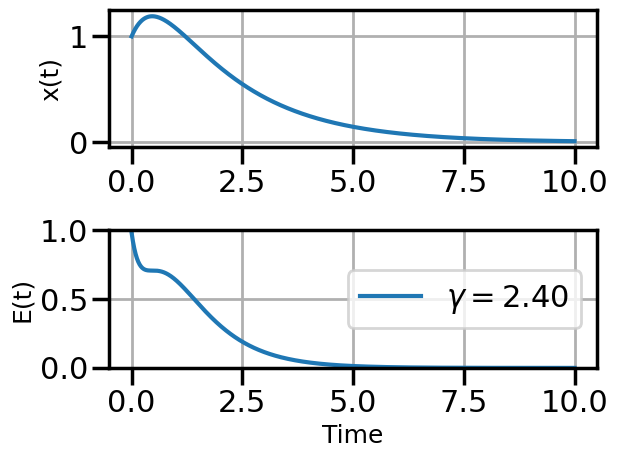

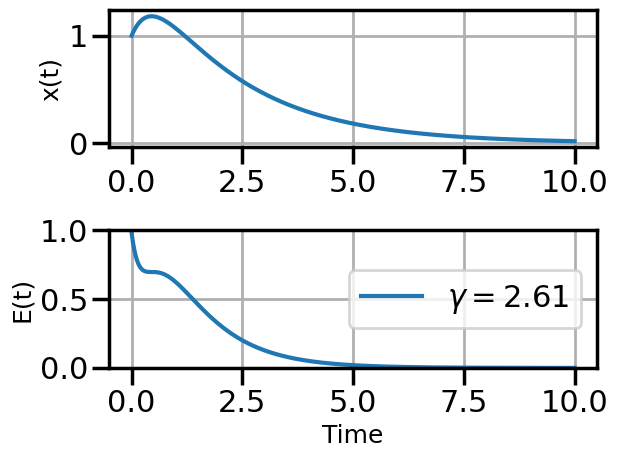

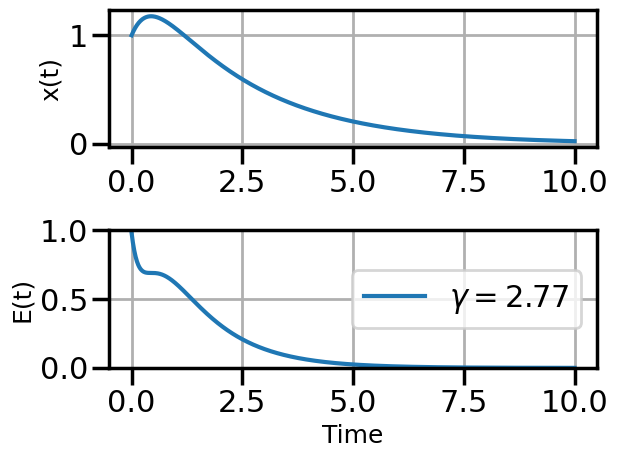

In [31]:
steps_SGD = plot_optimization(initial_gamma=0.05, 
                               num_steps=20,
                               optimizer=torch.optim.SGD,
                               opt_kwargs={'lr':0.05,'momentum':0.9})

#### LBFGS Example
(Warning: Per-run solves of LBFGS take a while, so don't set num_steps too high here)

In [32]:
steps_LBFGS = plot_optimization(initial_gamma=0.05,
                                num_steps=5,
                                optimizer=torch.optim.LBFGS,
                                opt_kwargs={'lr':0.3})

### Compare the steps taken

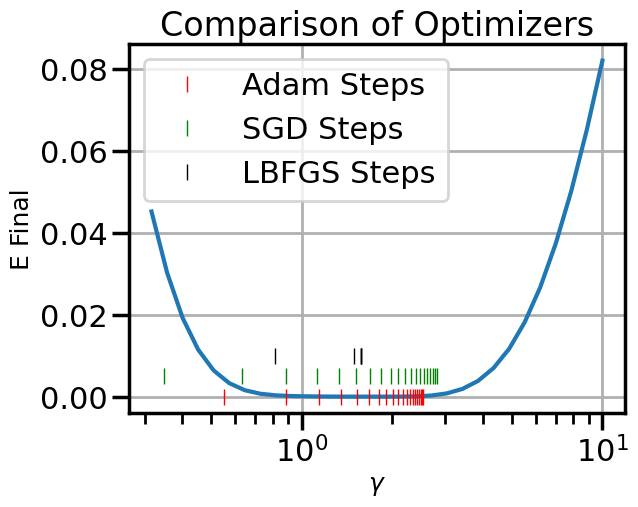

In [33]:
plt.figure()
plt.semilogx(gamma_plot,Efs)
steps_Adam = steps_Adam.flatten()
plt.plot(steps_Adam,[0.0]*len(steps_Adam),'|', color = 'r', label = 'Adam Steps')
plt.plot(steps_SGD,[0.005]*len(steps_SGD),'|', color = 'g', label = 'SGD Steps')
plt.plot(steps_LBFGS,[0.01]*len(steps_LBFGS),'|', color = 'k', label = 'LBFGS Steps')
plt.xlabel(r'$\gamma$')
plt.ylabel('E Final')
plt.title("Comparison of Optimizers")
plt.legend()
plt.show()